# Transit Detection Diagnostic

Investigate why transit detection works on KIC 6922244 (easy case) but fails on
KIC 11497958 (Kepler-90, multi-planet) and KIC 4138008 (Kepler-186, HZ planet).

**Goal**: Identify where in the pipeline the transit signal is lost.

**Method**: Process each target step-by-step, visualize at every stage, and
phase-fold on known literature periods to see if/when the dip is visible.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import sys
sys.path.insert(0, '.')

from src.lightcurve import clean_lightcurve, flatten_lightcurve

%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 4)
plt.rcParams['figure.dpi'] = 100

c:\Users\Yvonne Jin\Documents\code\astro_calib\venv\Lib\site-packages\lightkurve\prf\__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


## Known planet parameters (NASA Exoplanet Archive)

These are the literature values we are trying to recover.

In [2]:
# KIC 6922244 = Kepler-410A b -- the easy case
# G-type star, R* ~ 1.35 Rsun
PLANETS_6922244 = {
    'Kepler-410A b': {'period': 17.8336, 'depth_ppm': 490, 'Rp_Re': 2.84},
}

# KIC 11497958 = Kepler-90 -- multi-planet, 8 known planets
# G0V star, R* ~ 1.2 Rsun
PLANETS_11497958 = {
    'Kepler-90b': {'period': 7.008,   'depth_ppm': 62,   'Rp_Re': 1.31},
    'Kepler-90c': {'period': 8.719,   'depth_ppm': 51,   'Rp_Re': 1.19},
    'Kepler-90d': {'period': 59.737,  'depth_ppm': 297,  'Rp_Re': 2.88},
    'Kepler-90e': {'period': 91.939,  'depth_ppm': 255,  'Rp_Re': 2.67},
    'Kepler-90f': {'period': 124.914, 'depth_ppm': 300,  'Rp_Re': 2.89},
    'Kepler-90g': {'period': 210.607, 'depth_ppm': 2370, 'Rp_Re': 8.13},
    'Kepler-90h': {'period': 331.601, 'depth_ppm': 4600, 'Rp_Re': 11.32},
    'Kepler-90i': {'period': 14.449,  'depth_ppm': 63,   'Rp_Re': 1.32},
}

# KIC 4138008 = Kepler-186 -- M1 dwarf, R* ~ 0.47 Rsun
# Small star -> deeper relative transits for same planet size
PLANETS_4138008 = {
    'Kepler-186b': {'period': 3.887,   'depth_ppm': 340, 'Rp_Re': 1.07},
    'Kepler-186c': {'period': 7.267,   'depth_ppm': 466, 'Rp_Re': 1.25},
    'Kepler-186d': {'period': 13.343,  'depth_ppm': 585, 'Rp_Re': 1.40},
    'Kepler-186e': {'period': 22.408,  'depth_ppm': 480, 'Rp_Re': 1.27},
    'Kepler-186f': {'period': 129.944, 'depth_ppm': 408, 'Rp_Re': 1.17},
}

TARGETS = {
    'KIC 6922244':  {'planets': PLANETS_6922244,  'star': 'Kepler-410A', 'Rstar': 1.35},
    'KIC 11497958': {'planets': PLANETS_11497958, 'star': 'Kepler-90',   'Rstar': 1.20},
    'KIC 4138008':  {'planets': PLANETS_4138008,  'star': 'Kepler-186',  'Rstar': 0.47},
}

## Step 1: Download raw light curves

Download all available Kepler quarters for each target.

In [3]:
raw_data = {}

for target_id in TARGETS:
    print(f'\nSearching {target_id}...')
    search = lk.search_lightcurve(target_id, author='Kepler')
    print(f'  Found {len(search)} quarters')
    
    # Download and stitch
    lc_collection = search.download_all()
    lc = lc_collection.stitch()
    
    time = lc.time.value
    flux = lc.flux.value
    flux_err = lc.flux_err.value if lc.flux_err is not None else np.zeros_like(flux)
    
    # Basic stats
    baseline = time[-1] - time[0]
    cadence = np.median(np.diff(time)) * 86400
    print(f'  Points: {len(time)}, Baseline: {baseline:.1f} d, Cadence: {cadence:.0f} s')
    print(f'  Flux range: [{np.nanmin(flux):.6f}, {np.nanmax(flux):.6f}]')
    print(f'  Flux std: {np.nanstd(flux):.6f} ({np.nanstd(flux)*1e6:.0f} ppm)')
    
    raw_data[target_id] = {
        'time': time, 'flux': flux, 'flux_err': flux_err,
        'cadence_s': cadence, 'time_baseline_days': baseline,
        'mission': 'Kepler', 'author': 'Kepler',
        'n_sectors': len(search), 'n_points_raw': len(time),
    }


Searching KIC 6922244...
  Found 49 quarters
  Points: 1391255, Baseline: 1421.5 d, Cadence: 59 s
  Flux range: [0.967636, 1.581328]
  Flux std: 0.001869 (1869 ppm)

Searching KIC 11497958...
  Found 17 quarters
  Points: 192380, Baseline: 1459.5 d, Cadence: 59 s
  Flux range: [0.981767, 1.941902]
  Flux std: 0.003794 (3794 ppm)

Searching KIC 4138008...
  Found 17 quarters
  Points: 65031, Baseline: 1459.5 d, Cadence: 1765 s
  Flux range: [0.997891, 1.025194]
  Flux std: 0.000510 (510 ppm)


## Step 2: Raw light curve overview

Plot the full raw (stitched) light curve for each target. Look for:
- Overall variability level
- Gaps between quarters
- Obvious systematics or outliers

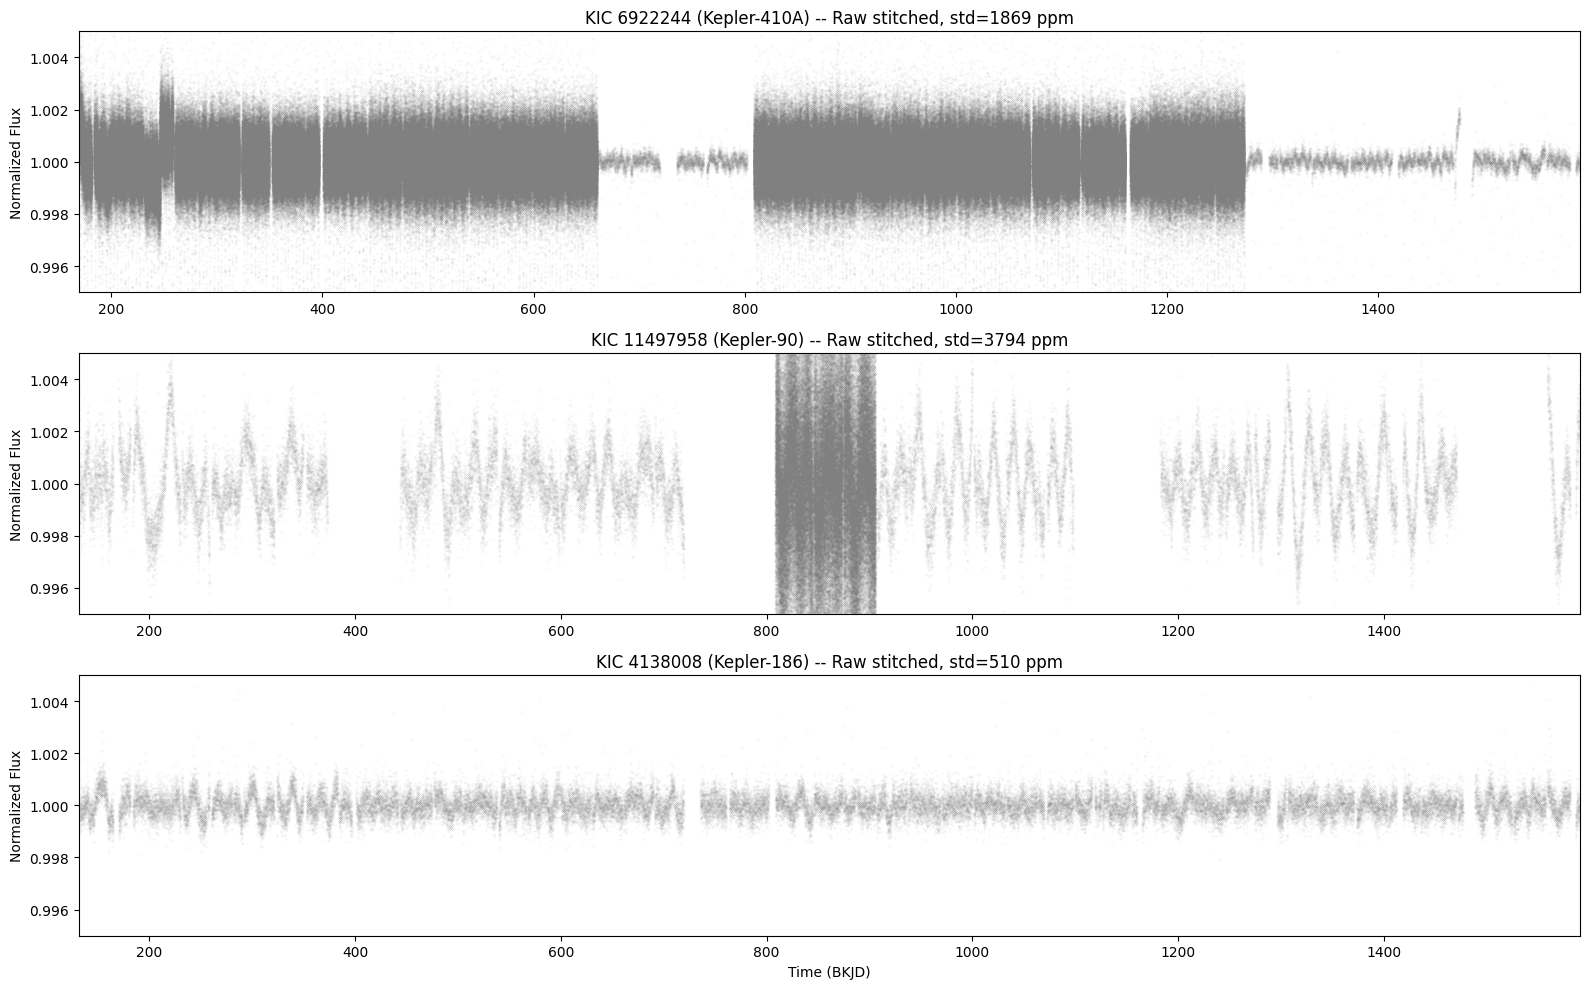

In [6]:
fig, axes = plt.subplots(3, 1, figsize=(16, 10))

for ax, (target_id, info) in zip(axes, TARGETS.items()):
    d = raw_data[target_id]
    ax.plot(d['time'], d['flux'], '.', ms=0.3, alpha=0.3, color='grey')
    ax.set_ylabel('Normalized Flux')
    ax.set_title(f"{target_id} ({info['star']}) -- Raw stitched, std={np.nanstd(d['flux'])*1e6:.0f} ppm")
    ax.set_xlim(d['time'][0], d['time'][-1])
    ax.set_ylim(0.995, 1.005)

axes[-1].set_xlabel('Time (BKJD)')
plt.tight_layout()
plt.show()

## Step 3: Clean (NaN + outlier removal)

Apply the same cleaning our pipeline uses. Check if the outlier clipping
at 5-sigma is removing transit points (transit dips could be flagged as outliers
if the clipping is too aggressive relative to transit depth).

In [7]:
cleaned_data = {}

for target_id in TARGETS:
    d = raw_data[target_id]
    
    # Count NaNs
    n_nan = np.sum(~np.isfinite(d['flux']))
    
    # Apply pipeline cleaning
    cleaned = clean_lightcurve(d, sigma_clip=5.0)
    
    n_removed = d['n_points_raw'] - cleaned['n_points_clean']
    print(f"{target_id}: {d['n_points_raw']} -> {cleaned['n_points_clean']} "
          f"(removed {n_removed}: {n_nan} NaN + {n_removed - n_nan} outliers)")
    
    # Check: what is the 5-sigma threshold vs expected transit depth?
    std = np.nanstd(cleaned['flux'])
    threshold_ppm = 5 * std * 1e6
    planets = TARGETS[target_id]['planets']
    shallowest = min(p['depth_ppm'] for p in planets.values())
    deepest = max(p['depth_ppm'] for p in planets.values())
    print(f"  5-sigma clip threshold: {threshold_ppm:.0f} ppm")
    print(f"  Planet depth range: {shallowest} - {deepest} ppm")
    if shallowest < threshold_ppm:
        print(f"  -> Shallow transits are BELOW 5-sigma, should survive clipping")
    else:
        print(f"  -> WARNING: transits may be clipped as outliers!")
    
    cleaned_data[target_id] = cleaned

KIC 6922244: 1391255 -> 1381215 (removed 10040: ——— NaN +  ——— outliers)
  5-sigma clip threshold: 7801 ppm
  Planet depth range: 490 - 490 ppm
  -> Shallow transits are BELOW 5-sigma, should survive clipping
KIC 11497958: 192380 -> 192057 (removed 323: ——— NaN + —— outliers)
  5-sigma clip threshold: 15220 ppm
  Planet depth range: 51 - 4600 ppm
  -> Shallow transits are BELOW 5-sigma, should survive clipping
KIC 4138008: 65031 -> 64730 (removed 301: ——— NaN + —— outliers)
  5-sigma clip threshold: 2226 ppm
  Planet depth range: 340 - 585 ppm
  -> Shallow transits are BELOW 5-sigma, should survive clipping


## Step 4: Flatten with different window sizes

The current pipeline uses window_length=1001. Test multiple values to see how
the transit signal is affected. A window too small eats the transit; too large
leaves stellar variability that drowns the signal.

For Kepler 30-min cadence: 1001 cadences ~ 20.8 days.

In [8]:
WINDOW_LENGTHS = [101, 301, 501, 1001, 2001]

flattened_data = {}  # {target_id: {window: lc_data}}

for target_id in TARGETS:
    print(f'\n{target_id}:')
    flattened_data[target_id] = {}
    d = cleaned_data[target_id]
    cadence_days = d['cadence_s'] / 86400.0
    
    for wl in WINDOW_LENGTHS:
        flat = flatten_lightcurve(d, window_length=wl)
        std_ppm = np.nanstd(flat['flux_flat']) * 1e6
        window_days = wl * cadence_days
        print(f'  window={wl} ({window_days:.1f} d): residual std = {std_ppm:.0f} ppm')
        flattened_data[target_id][wl] = flat


KIC 6922244:
  window=101 (0.1 d): residual std = 1206 ppm
  window=301 (0.2 d): residual std = 1348 ppm
  window=501 (0.3 d): residual std = 1362 ppm
  window=1001 (0.7 d): residual std = 1372 ppm
  window=2001 (1.4 d): residual std = 1377 ppm

KIC 11497958:
  window=101 (0.1 d): residual std = 2807 ppm
  window=301 (0.2 d): residual std = 2848 ppm
  window=501 (0.3 d): residual std = 2857 ppm
  window=1001 (0.7 d): residual std = 2864 ppm
  window=2001 (1.4 d): residual std = 2869 ppm

KIC 4138008:
  window=101 (2.1 d): residual std = 379 ppm
  window=301 (6.2 d): residual std = 384 ppm
  window=501 (10.2 d): residual std = 391 ppm
  window=1001 (20.5 d): residual std = 418 ppm
  window=2001 (40.9 d): residual std = 440 ppm


## Step 5: Phase-fold on known periods -- the key diagnostic

For each target, fold the flattened light curve at each known planet's period.
Bin into ~200 phase bins and look for the transit dip.

If the dip is visible in the binned phase fold -> BLS should find it.
If not -> the signal is lost before BLS even runs.

In [9]:
def phase_fold_and_bin(time, flux, period, n_bins=200):
    """Phase-fold and bin a light curve. Returns bin_centers, bin_medians, bin_std, n_per_bin."""
    phase = (time % period) / period
    # Shift so transit is at phase=0.5 for visibility
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    bin_medians = np.full(n_bins, np.nan)
    bin_stds = np.full(n_bins, np.nan)
    bin_counts = np.zeros(n_bins, dtype=int)
    
    for i in range(n_bins):
        mask = (phase >= bin_edges[i]) & (phase < bin_edges[i + 1])
        if np.sum(mask) > 0:
            bin_medians[i] = np.median(flux[mask])
            bin_stds[i] = np.std(flux[mask]) / np.sqrt(np.sum(mask))  # SEM
            bin_counts[i] = np.sum(mask)
    
    return bin_centers, bin_medians, bin_stds, bin_counts


def measure_folded_depth(bin_centers, bin_medians, transit_duration_frac=0.02):
    """Estimate transit depth from binned phase-folded data.
    
    Finds the deepest contiguous dip and measures its depth relative
    to the out-of-transit baseline.
    """
    valid = np.isfinite(bin_medians)
    if np.sum(valid) < 10:
        return 0, 0, 0
    
    baseline = np.median(bin_medians[valid])
    min_idx = np.nanargmin(bin_medians)
    min_val = bin_medians[min_idx]
    depth = baseline - min_val
    depth_ppm = depth * 1e6
    
    # SNR: depth / std of out-of-transit bins
    # Exclude 5% around the minimum as "in transit"
    n_bins = len(bin_centers)
    exclude = max(2, int(n_bins * 0.05))
    oot_mask = np.ones(n_bins, dtype=bool)
    for j in range(min_idx - exclude, min_idx + exclude + 1):
        oot_mask[j % n_bins] = False
    oot_std = np.nanstd(bin_medians[oot_mask & valid])
    snr = depth / oot_std if oot_std > 0 else 0
    
    return depth_ppm, snr, min_idx


=== KIC 6922244 (Kepler-410A) -- window=1001 ===
  Kepler-410A b: P=17.834 d, expected=490 ppm, measured=27 ppm, SNR=5.6 -> DETECTED


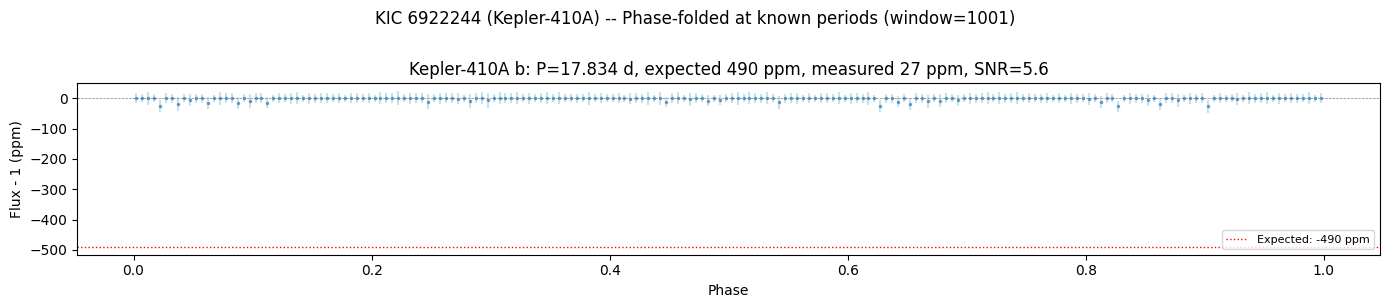


=== KIC 11497958 (Kepler-90) -- window=1001 ===
  Kepler-90b: P=7.008 d, expected=62 ppm, measured=0 ppm, SNR=0.0 -> NOT VISIBLE
  Kepler-90c: P=8.719 d, expected=51 ppm, measured=0 ppm, SNR=0.0 -> NOT VISIBLE
  Kepler-90d: P=59.737 d, expected=297 ppm, measured=0 ppm, SNR=0.0 -> NOT VISIBLE
  Kepler-90e: P=91.939 d, expected=255 ppm, measured=0 ppm, SNR=0.0 -> NOT VISIBLE
  Kepler-90f: P=124.914 d, expected=300 ppm, measured=0 ppm, SNR=0.0 -> NOT VISIBLE
  Kepler-90g: P=210.607 d, expected=2370 ppm, measured=0 ppm, SNR=0.0 -> NOT VISIBLE
  Kepler-90h: P=331.601 d, expected=4600 ppm, measured=0 ppm, SNR=0.0 -> NOT VISIBLE
  Kepler-90i: P=14.449 d, expected=63 ppm, measured=0 ppm, SNR=0.0 -> NOT VISIBLE


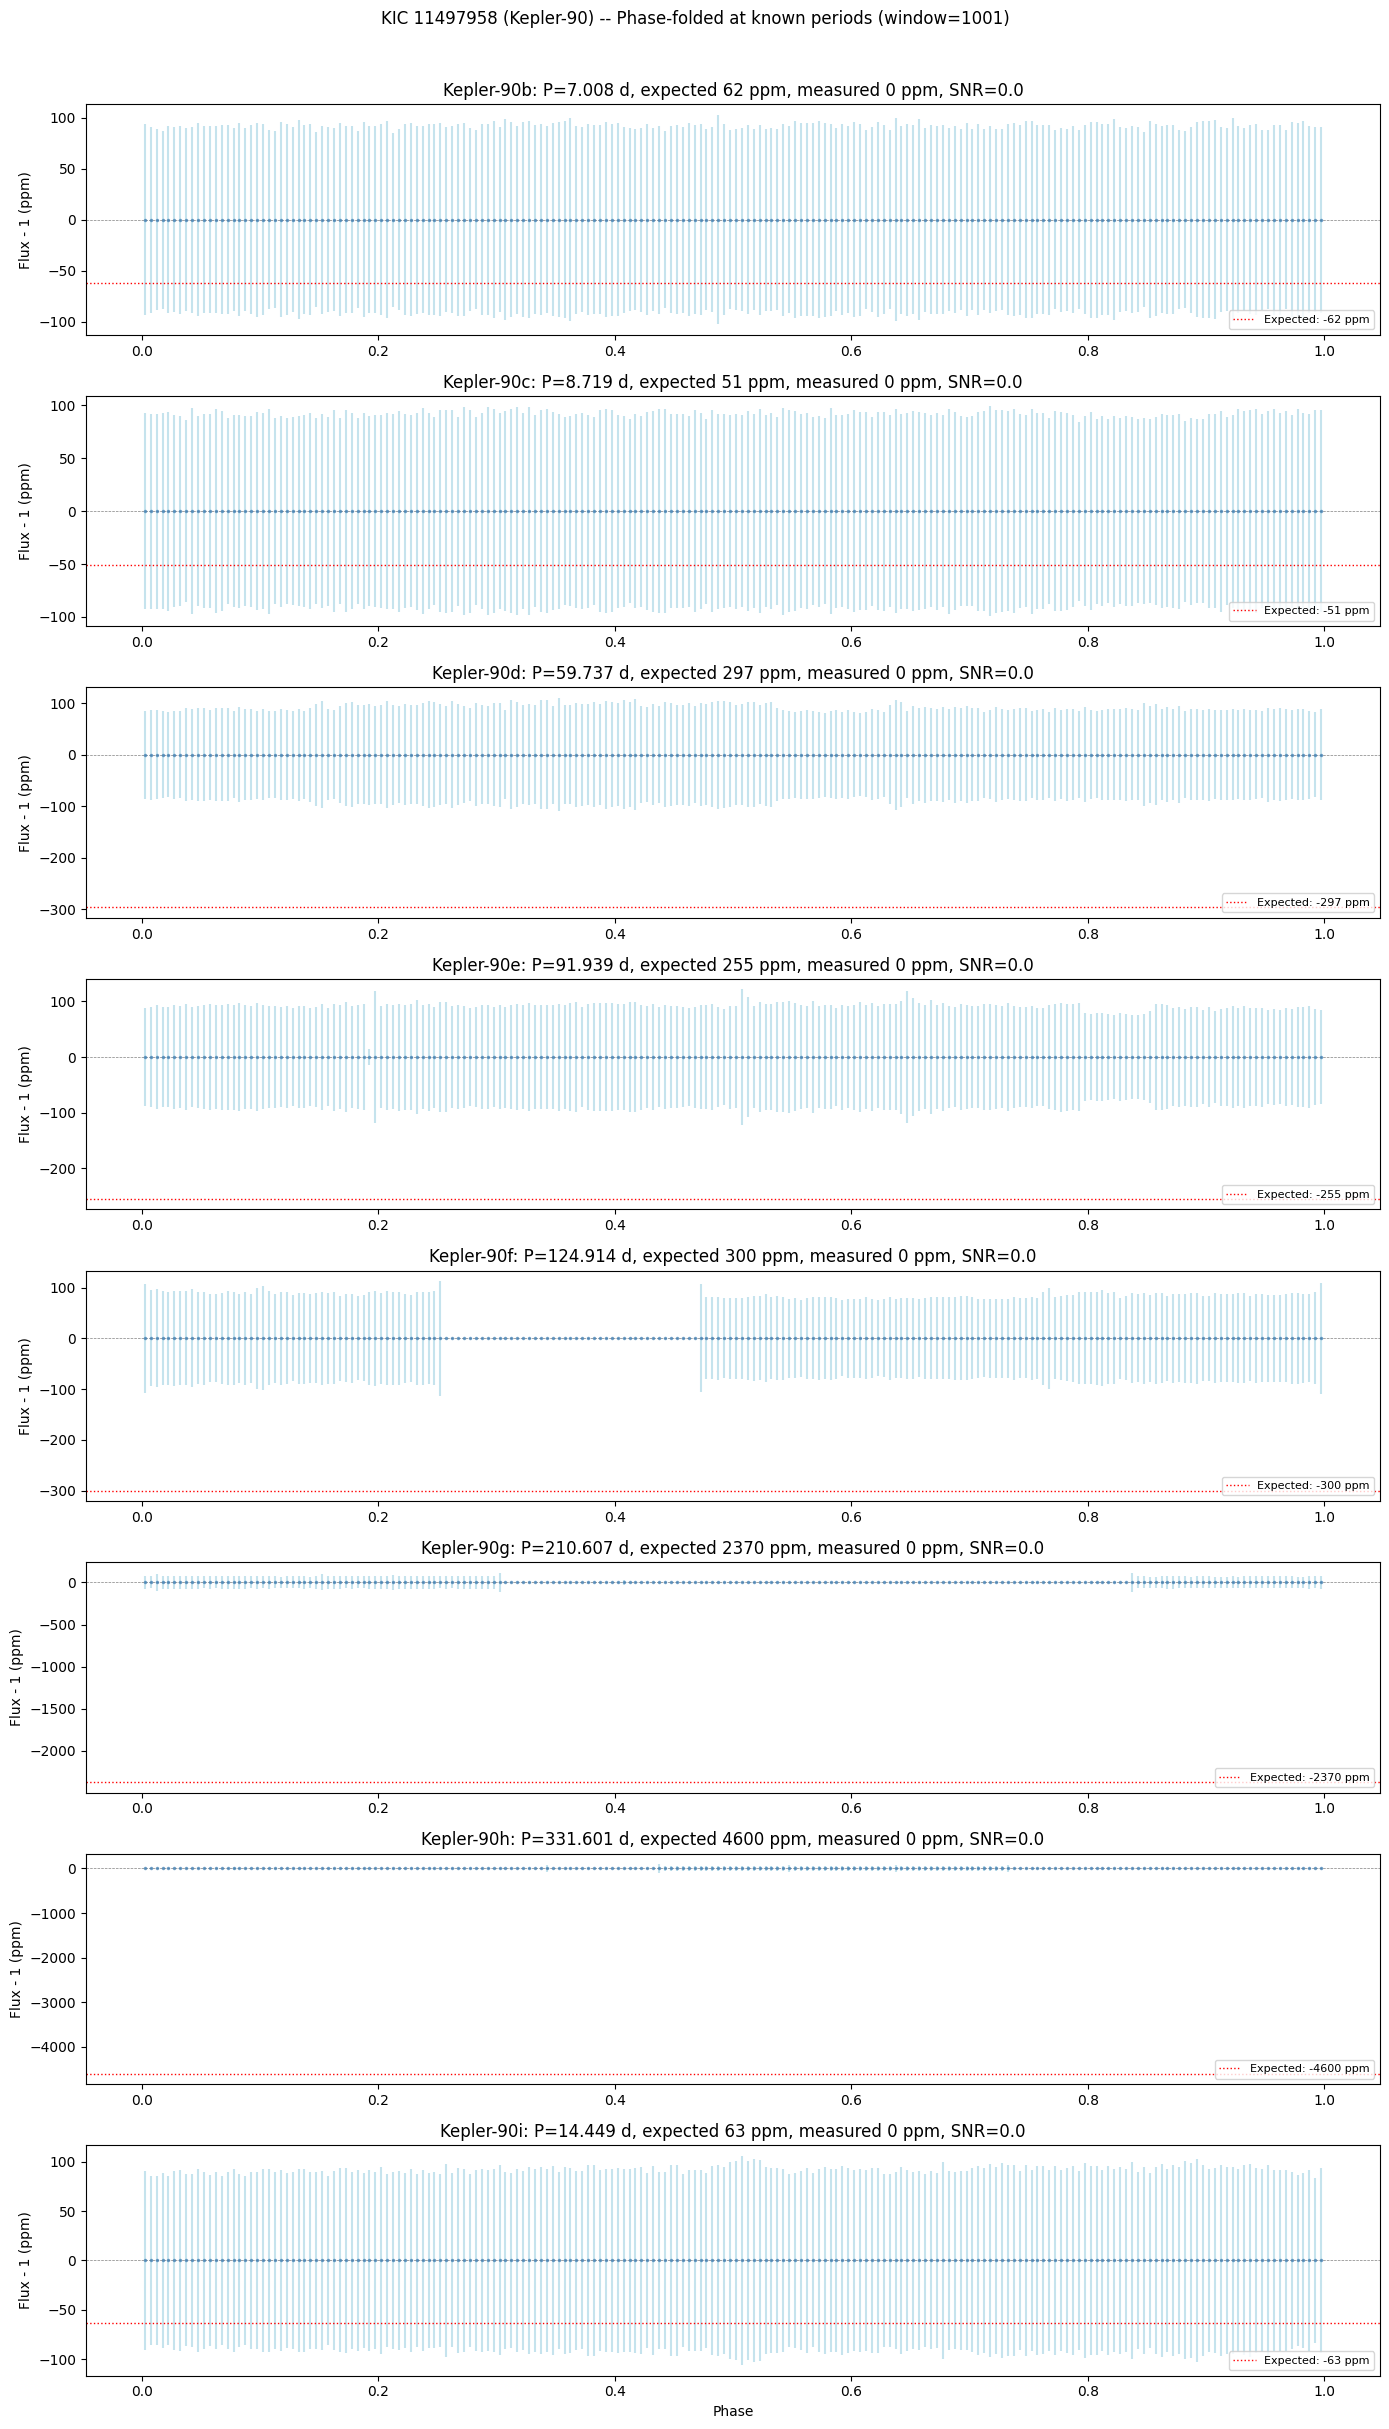


=== KIC 4138008 (Kepler-186) -- window=1001 ===
  Kepler-186b: P=3.887 d, expected=340 ppm, measured=88 ppm, SNR=3.2 -> DETECTED
  Kepler-186c: P=7.267 d, expected=466 ppm, measured=73 ppm, SNR=2.7 -> MARGINAL
  Kepler-186d: P=13.343 d, expected=585 ppm, measured=106 ppm, SNR=3.0 -> DETECTED
  Kepler-186e: P=22.408 d, expected=480 ppm, measured=75 ppm, SNR=2.6 -> MARGINAL
  Kepler-186f: P=129.944 d, expected=408 ppm, measured=168 ppm, SNR=3.4 -> DETECTED


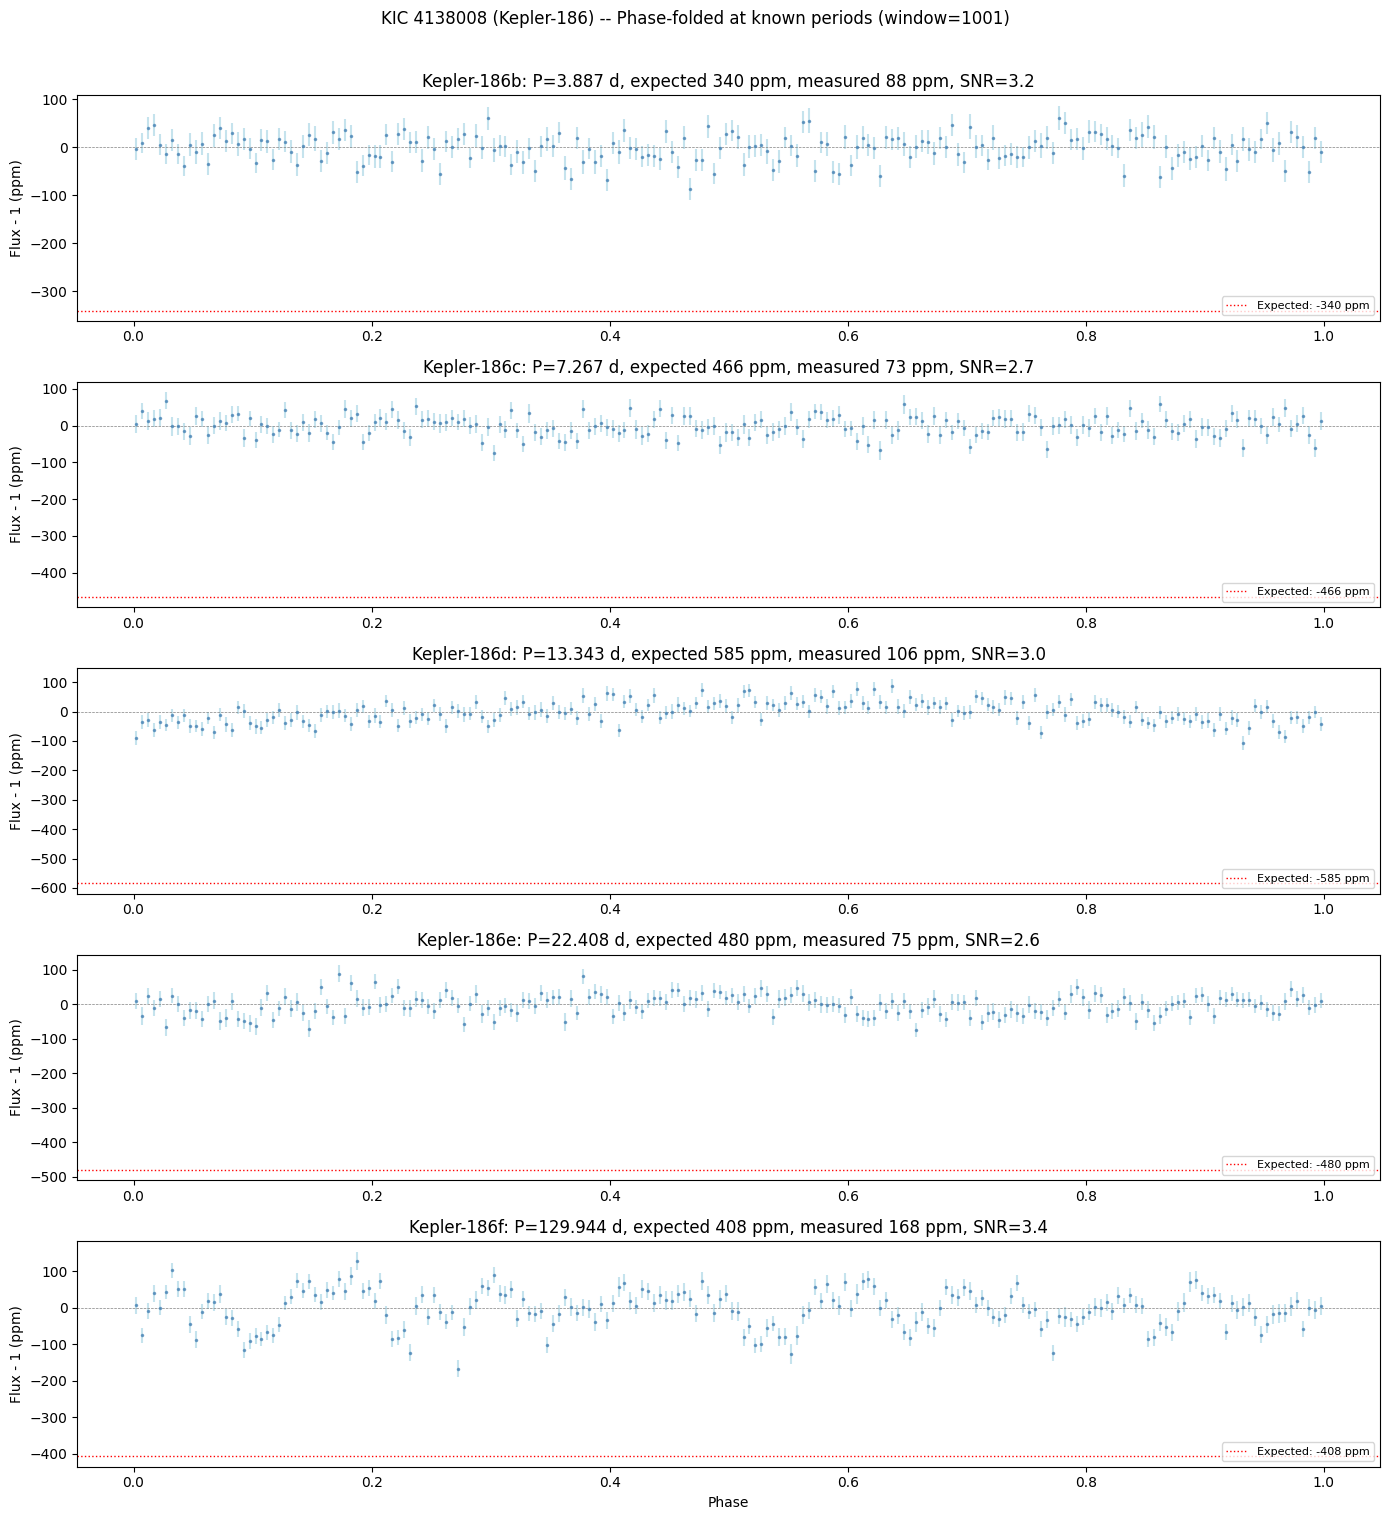

In [10]:
# Use the default pipeline window (1001) for this diagnostic
DIAG_WINDOW = 1001

for target_id, info in TARGETS.items():
    planets = info['planets']
    flat = flattened_data[target_id][DIAG_WINDOW]
    time = flat['time']
    flux = flat['flux_flat']
    
    n_planets = len(planets)
    fig, axes = plt.subplots(n_planets, 1, figsize=(14, 3 * n_planets))
    if n_planets == 1:
        axes = [axes]
    
    print(f'\n=== {target_id} ({info["star"]}) -- window={DIAG_WINDOW} ===')
    
    for ax, (pname, pinfo) in zip(axes, planets.items()):
        period = pinfo['period']
        expected_depth = pinfo['depth_ppm']
        
        bc, bm, bs, bn = phase_fold_and_bin(time, flux, period, n_bins=200)
        depth_ppm, snr, min_idx = measure_folded_depth(bc, bm)
        
        # Plot
        ax.errorbar(bc, (bm - 1) * 1e6, yerr=bs * 1e6, fmt='.', ms=3,
                    color='steelblue', ecolor='lightblue', alpha=0.7)
        ax.axhline(0, color='grey', ls='--', lw=0.5)
        ax.axhline(-expected_depth, color='red', ls=':', lw=1,
                   label=f'Expected: -{expected_depth} ppm')
        ax.set_ylabel('Flux - 1 (ppm)')
        ax.set_title(f'{pname}: P={period:.3f} d, expected {expected_depth} ppm, '
                     f'measured {depth_ppm:.0f} ppm, SNR={snr:.1f}')
        ax.legend(loc='lower right', fontsize=8)
        
        status = 'DETECTED' if snr > 3 else 'MARGINAL' if snr > 1.5 else 'NOT VISIBLE'
        print(f'  {pname}: P={period:.3f} d, expected={expected_depth} ppm, '
              f'measured={depth_ppm:.0f} ppm, SNR={snr:.1f} -> {status}')
    
    axes[-1].set_xlabel('Phase')
    plt.suptitle(f'{target_id} ({info["star"]}) -- Phase-folded at known periods (window={DIAG_WINDOW})',
                 fontsize=12, y=1.01)
    plt.tight_layout()
    plt.show()

## Step 6: Window size sensitivity

For the planets that are NOT visible above, try different flattening windows.
Pick the deepest planet from each hard target and sweep window sizes.

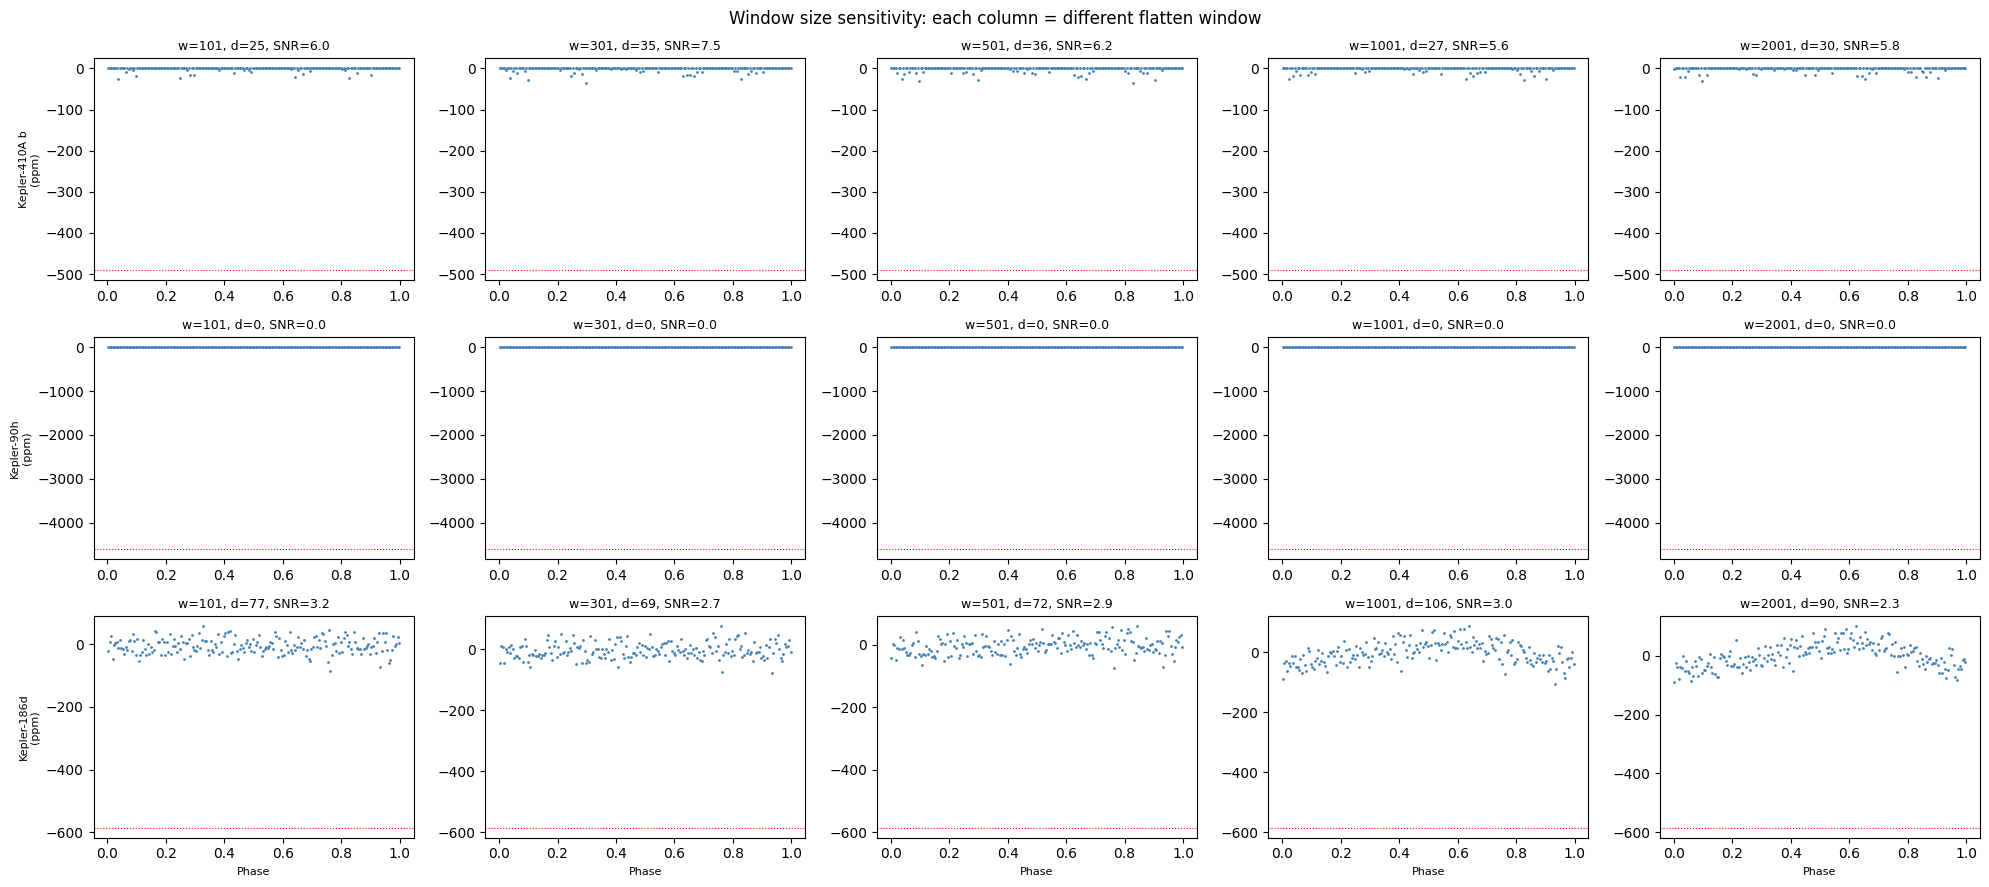

In [11]:
# Pick test planets: deepest from each target for best chance of detection
TEST_PLANETS = {
    'KIC 6922244':  ('Kepler-410A b', 17.8336),   # 490 ppm -- should work
    'KIC 11497958': ('Kepler-90h', 331.601),       # 4600 ppm -- deepest
    'KIC 4138008':  ('Kepler-186d', 13.343),       # 585 ppm -- deepest short-period
}

fig, axes = plt.subplots(len(TEST_PLANETS), len(WINDOW_LENGTHS),
                         figsize=(4 * len(WINDOW_LENGTHS), 3 * len(TEST_PLANETS)))

for row, (target_id, (pname, period)) in enumerate(TEST_PLANETS.items()):
    expected = TARGETS[target_id]['planets'][pname]['depth_ppm']
    
    for col, wl in enumerate(WINDOW_LENGTHS):
        ax = axes[row][col]
        flat = flattened_data[target_id][wl]
        bc, bm, bs, bn = phase_fold_and_bin(flat['time'], flat['flux_flat'],
                                             period, n_bins=200)
        depth_ppm, snr, _ = measure_folded_depth(bc, bm)
        
        ax.plot(bc, (bm - 1) * 1e6, '.', ms=2, color='steelblue')
        ax.axhline(-expected, color='red', ls=':', lw=0.8)
        ax.set_title(f'w={wl}, d={depth_ppm:.0f}, SNR={snr:.1f}', fontsize=9)
        
        if col == 0:
            ax.set_ylabel(f'{pname}\n(ppm)', fontsize=8)
        if row == len(TEST_PLANETS) - 1:
            ax.set_xlabel('Phase', fontsize=8)

plt.suptitle('Window size sensitivity: each column = different flatten window', fontsize=12)
plt.tight_layout()
plt.show()

## Step 7: Try lightkurve's built-in flatten with sigma masking

lightkurve's `flatten()` has a `sigma` parameter that masks low outliers
(i.e., transit dips) during the trend fit so they aren't absorbed into
the baseline. This is "transit-aware" detrending.

Compare: our pipeline flatten (no masking) vs lightkurve flatten with sigma=3.

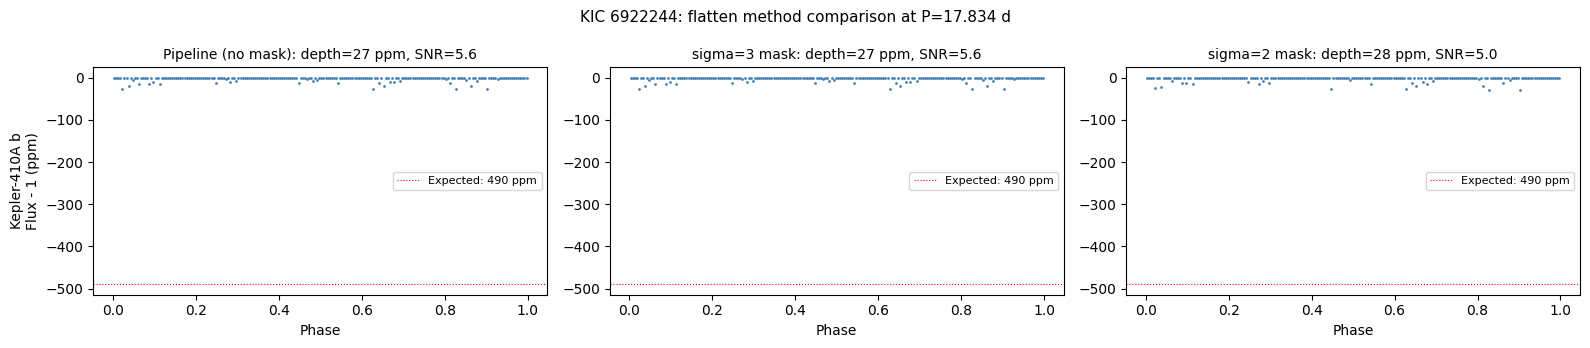

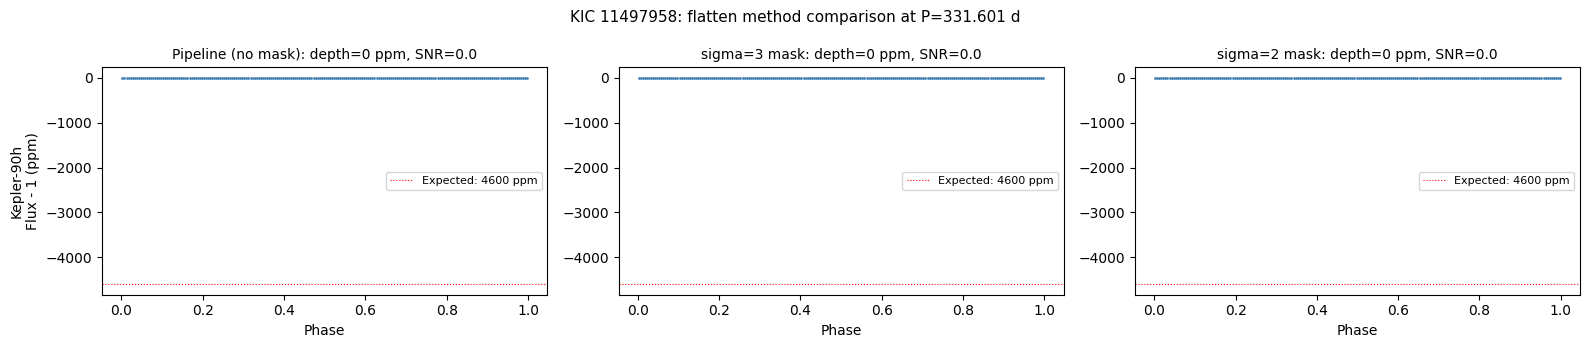

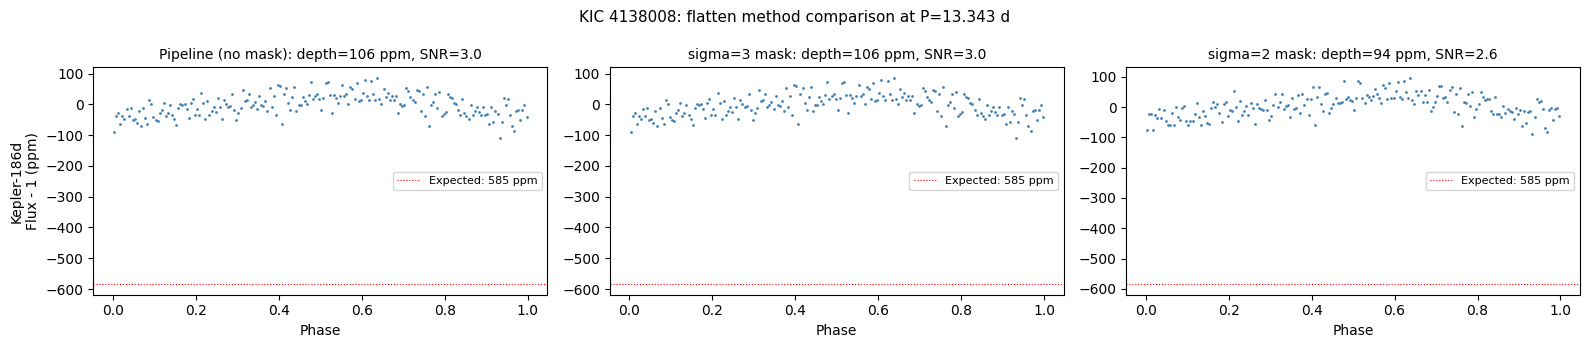

In [12]:
# Transit-aware flattening comparison
for target_id, (pname, period) in TEST_PLANETS.items():
    expected = TARGETS[target_id]['planets'][pname]['depth_ppm']
    d = cleaned_data[target_id]
    
    # Build lightkurve object
    lc_obj = lk.LightCurve(time=d['time'], flux=d['flux'], flux_err=d['flux_err'])
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 3.5))
    
    methods = [
        ('Pipeline (no mask)', lc_obj.flatten(window_length=1001)),
        ('sigma=3 mask',       lc_obj.flatten(window_length=1001, sigma=3)),
        ('sigma=2 mask',       lc_obj.flatten(window_length=1001, sigma=2)),
    ]
    
    for ax, (label, lc_flat) in zip(axes, methods):
        flux_flat = lc_flat.flux.value
        time_flat = lc_flat.time.value
        
        bc, bm, bs, bn = phase_fold_and_bin(time_flat, flux_flat, period, n_bins=200)
        depth_ppm, snr, _ = measure_folded_depth(bc, bm)
        
        ax.plot(bc, (bm - 1) * 1e6, '.', ms=2, color='steelblue')
        ax.axhline(-expected, color='red', ls=':', lw=0.8, label=f'Expected: {expected} ppm')
        ax.set_title(f'{label}: depth={depth_ppm:.0f} ppm, SNR={snr:.1f}', fontsize=10)
        ax.set_xlabel('Phase')
        ax.legend(fontsize=8)
    
    axes[0].set_ylabel(f'{pname}\nFlux - 1 (ppm)')
    plt.suptitle(f'{target_id}: flatten method comparison at P={period:.3f} d', fontsize=11)
    plt.tight_layout()
    plt.show()

## Step 8: Noise floor analysis

What is the theoretical detection limit for each target?
- CDPP (Combined Differential Photometric Precision) at transit-relevant timescales
- Expected SNR = depth * sqrt(n_transits * n_points_in_transit) / noise_per_point

In [13]:
for target_id, info in TARGETS.items():
    flat = flattened_data[target_id][DIAG_WINDOW]
    time = flat['time']
    flux = flat['flux_flat']
    baseline = time[-1] - time[0]
    cadence_d = flat['cadence_s'] / 86400.0
    
    # Point-to-point scatter (proxy for CDPP)
    scatter_ppm = np.nanstd(np.diff(flux)) / np.sqrt(2) * 1e6
    
    print(f'\n=== {target_id} ({info["star"]}) ===')
    print(f'  Baseline: {baseline:.0f} d, Cadence: {flat["cadence_s"]:.0f} s')
    print(f'  Point-to-point scatter: {scatter_ppm:.0f} ppm')
    print(f'  Overall std: {np.nanstd(flux)*1e6:.0f} ppm')
    
    for pname, pinfo in info['planets'].items():
        period = pinfo['period']
        depth = pinfo['depth_ppm']
        
        # Rough estimates
        n_transits = baseline / period
        # Assume transit duration ~ P^(1/3) * 3 hours (rough scaling)
        duration_h = 3.0 * (period / 10.0) ** (1.0/3.0)
        duration_d = duration_h / 24.0
        n_pts_per_transit = duration_d / cadence_d
        
        # Expected BLS SNR ~ depth * sqrt(n_transits * n_pts_per_transit) / scatter
        expected_snr = depth * np.sqrt(n_transits * n_pts_per_transit) / scatter_ppm
        
        detectable = 'YES' if expected_snr > 6 else 'MAYBE' if expected_snr > 3 else 'NO'
        print(f'  {pname}: depth={depth} ppm, ~{n_transits:.0f} transits, '
              f'~{n_pts_per_transit:.0f} pts/transit, expected_SNR={expected_snr:.1f} -> {detectable}')


=== KIC 6922244 (Kepler-410A) ===
  Baseline: 1421 d, Cadence: 59 s
  Point-to-point scatter: 915 ppm
  Overall std: 1372 ppm
  Kepler-410A b: depth=490 ppm, ~80 transits, ~223 pts/transit, expected_SNR=71.3 -> YES

=== KIC 11497958 (Kepler-90) ===
  Baseline: 1459 d, Cadence: 59 s
  Point-to-point scatter: 2824 ppm
  Overall std: 2864 ppm
  Kepler-90b: depth=62 ppm, ~208 transits, ~163 pts/transit, expected_SNR=4.0 -> MAYBE
  Kepler-90c: depth=51 ppm, ~167 transits, ~175 pts/transit, expected_SNR=3.1 -> MAYBE
  Kepler-90d: depth=297 ppm, ~24 transits, ~333 pts/transit, expected_SNR=9.5 -> YES
  Kepler-90e: depth=255 ppm, ~16 transits, ~384 pts/transit, expected_SNR=7.1 -> YES
  Kepler-90f: depth=300 ppm, ~12 transits, ~426 pts/transit, expected_SNR=7.5 -> YES
  Kepler-90g: depth=2370 ppm, ~7 transits, ~507 pts/transit, expected_SNR=49.7 -> YES
  Kepler-90h: depth=4600 ppm, ~4 transits, ~590 pts/transit, expected_SNR=83.0 -> YES
  Kepler-90i: depth=63 ppm, ~101 transits, ~207 pts/tran

## Step 9: BLS power spectrum comparison

Run BLS on each target and plot the full power spectrum. Mark known planet
periods to see if they correspond to any peaks (even below threshold).

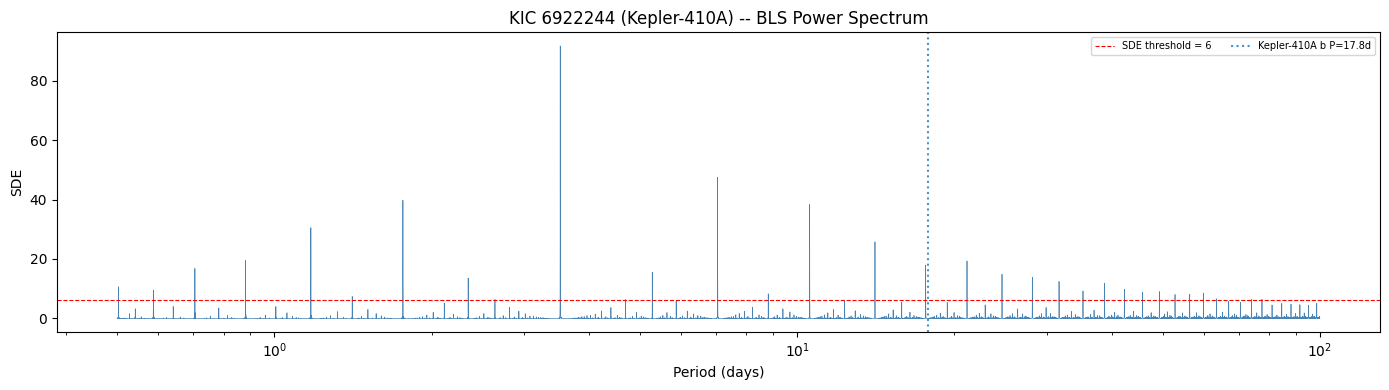


BLS peaks near known planets (KIC 6922244):
  Kepler-410A b: known P=17.834 d, nearest BLS peak at P=17.612 d, SDE=17.9 -> PEAK


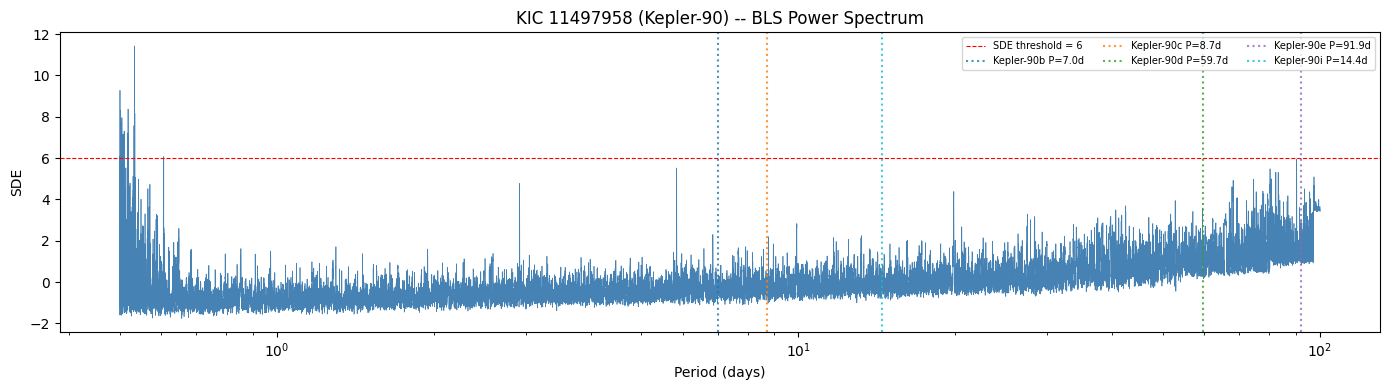


BLS peaks near known planets (KIC 11497958):
  Kepler-90b: known P=7.008 d, nearest BLS peak at P=6.857 d, SDE=2.3 -> sub-threshold
  Kepler-90c: known P=8.719 d, nearest BLS peak at P=8.766 d, SDE=2.2 -> sub-threshold
  Kepler-90d: known P=59.737 d, nearest BLS peak at P=59.522 d, SDE=3.6 -> sub-threshold
  Kepler-90e: known P=91.939 d, nearest BLS peak at P=90.203 d, SDE=6.0 -> sub-threshold
  Kepler-90f: P=124.9 d -- beyond search range
  Kepler-90g: P=210.6 d -- beyond search range
  Kepler-90h: P=331.6 d -- beyond search range
  Kepler-90i: known P=14.449 d, nearest BLS peak at P=14.985 d, SDE=1.8 -> sub-threshold


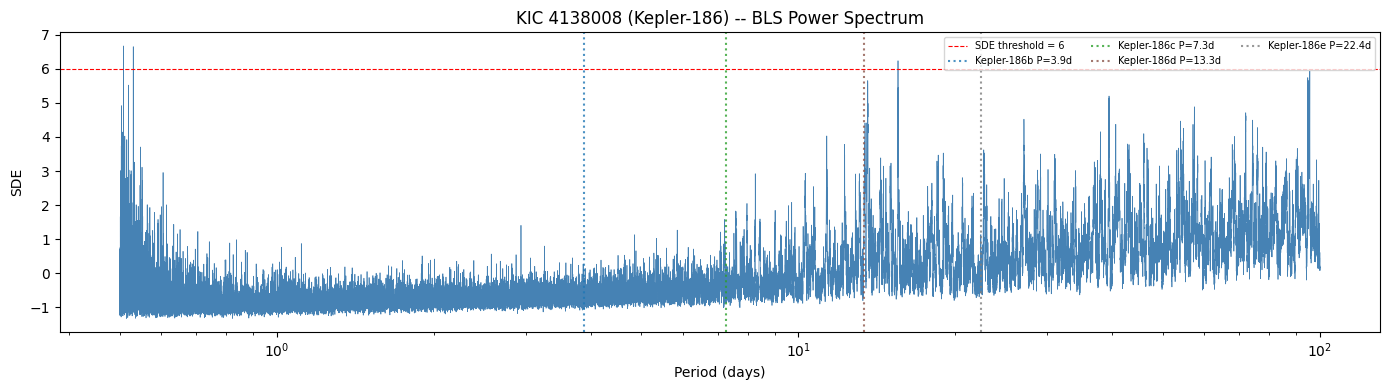


BLS peaks near known planets (KIC 4138008):
  Kepler-186b: known P=3.887 d, nearest BLS peak at P=3.867 d, SDE=0.3 -> sub-threshold
  Kepler-186c: known P=7.267 d, nearest BLS peak at P=7.579 d, SDE=1.8 -> sub-threshold
  Kepler-186d: known P=13.343 d, nearest BLS peak at P=13.580 d, SDE=5.7 -> sub-threshold
  Kepler-186e: known P=22.408 d, nearest BLS peak at P=22.666 d, SDE=3.6 -> sub-threshold
  Kepler-186f: P=129.9 d -- beyond search range


In [14]:
from astropy.timeseries import BoxLeastSquares

for target_id, info in TARGETS.items():
    flat = flattened_data[target_id][DIAG_WINDOW]
    time = flat['time']
    flux = flat['flux_flat']
    baseline = time[-1] - time[0]
    
    # BLS
    bls = BoxLeastSquares(time, flux)
    max_p = min(100.0, baseline / 2.0)
    periods = np.geomspace(0.5, max_p, 50000)
    durations = np.linspace(0.01, 0.45, 20)
    result = bls.power(periods, durations)
    
    power = np.asarray(result.power, dtype=float)
    sde = (power - np.mean(power)) / np.std(power)
    
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(periods, sde, color='steelblue', lw=0.5)
    ax.axhline(6, color='red', ls='--', lw=0.8, label='SDE threshold = 6')
    
    # Mark known planet periods
    colors = plt.cm.tab10(np.linspace(0, 1, len(info['planets'])))
    for (pname, pinfo), c in zip(info['planets'].items(), colors):
        p = pinfo['period']
        if p <= max_p:
            ax.axvline(p, color=c, ls=':', lw=1.5, alpha=0.8, label=f'{pname} P={p:.1f}d')
    
    ax.set_xlabel('Period (days)')
    ax.set_ylabel('SDE')
    ax.set_xscale('log')
    ax.set_title(f'{target_id} ({info["star"]}) -- BLS Power Spectrum')
    ax.legend(fontsize=7, ncol=3, loc='upper right')
    plt.tight_layout()
    plt.show()
    
    # Print peaks near known periods
    print(f'\nBLS peaks near known planets ({target_id}):')
    for pname, pinfo in info['planets'].items():
        p = pinfo['period']
        if p > max_p:
            print(f'  {pname}: P={p:.1f} d -- beyond search range')
            continue
        # Find closest period in grid
        idx = np.argmin(np.abs(periods - p))
        # Find local max within +/- 5% of known period
        mask = (periods > p * 0.95) & (periods < p * 1.05)
        if np.any(mask):
            local_max_sde = np.max(sde[mask])
            local_max_idx = np.where(mask)[0][np.argmax(sde[mask])]
            local_max_p = periods[local_max_idx]
        else:
            local_max_sde = sde[idx]
            local_max_p = periods[idx]
        
        status = 'PEAK' if local_max_sde > 6 else 'sub-threshold'
        print(f'  {pname}: known P={p:.3f} d, nearest BLS peak at P={local_max_p:.3f} d, '
              f'SDE={local_max_sde:.1f} -> {status}')

## Step 10: Summary & Conclusions

Collect all diagnostic results into a summary table.

In [15]:
print('=' * 100)
print(f'{"Planet":<18s} {"Period":>8s} {"Depth":>8s} {"Scatter":>8s} '
      f'{"Fold SNR":>9s} {"BLS vis":>8s} {"Diagnosis"}')
print('-' * 100)

for target_id, info in TARGETS.items():
    flat = flattened_data[target_id][DIAG_WINDOW]
    scatter_ppm = np.nanstd(np.diff(flat['flux_flat'])) / np.sqrt(2) * 1e6
    
    for pname, pinfo in info['planets'].items():
        period = pinfo['period']
        depth = pinfo['depth_ppm']
        
        bc, bm, bs, bn = phase_fold_and_bin(
            flat['time'], flat['flux_flat'], period, n_bins=200)
        fold_depth, fold_snr, _ = measure_folded_depth(bc, bm)
        
        if fold_snr > 3:
            diagnosis = 'Signal visible in fold -> BLS should find it'
            bls_vis = 'YES'
        elif fold_snr > 1.5:
            diagnosis = 'Marginal in fold -> may need better detrending'
            bls_vis = 'MAYBE'
        elif depth < scatter_ppm * 0.5:
            diagnosis = 'Below noise floor -> not detectable with this data'
            bls_vis = 'NO'
        else:
            diagnosis = 'Signal lost in detrending -> try sigma-mask flatten'
            bls_vis = 'NO'
        
        print(f'{pname:<18s} {period:>8.3f} {depth:>7d}  {scatter_ppm:>7.0f}  '
              f'{fold_snr:>8.1f}  {bls_vis:>7s}  {diagnosis}')
    print()

print('=' * 100)
print('\nNext steps based on diagnosis:')
print('  - "Signal lost in detrending" -> implement sigma-clipping flatten')
print('  - "Below noise floor" -> not recoverable with current data/method')
print('  - "Marginal" -> try different window sizes or iterative detrending')
print('  - "BLS should find it" -> check BLS period grid resolution / SDE threshold')

Planet               Period    Depth  Scatter  Fold SNR  BLS vis Diagnosis
----------------------------------------------------------------------------------------------------
Kepler-410A b        17.834     490      915       5.6      YES  Signal visible in fold -> BLS should find it

Kepler-90b            7.008      62     2824       0.0       NO  Below noise floor -> not detectable with this data
Kepler-90c            8.719      51     2824       0.0       NO  Below noise floor -> not detectable with this data
Kepler-90d           59.737     297     2824       0.0       NO  Below noise floor -> not detectable with this data
Kepler-90e           91.939     255     2824       0.0       NO  Below noise floor -> not detectable with this data
Kepler-90f          124.914     300     2824       0.0       NO  Below noise floor -> not detectable with this data
Kepler-90g          210.607    2370     2824       0.0       NO  Signal lost in detrending -> try sigma-mask flatten
Kepler-90h      